In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
import pandas as pd
from joblib import load, dump

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sns.set_style("whitegrid")
plt.rc('font', size=14)

In [29]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from random import randint, shuffle as sf

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score, 
                             accuracy_score, 
                             matthews_corrcoef,
                             confusion_matrix)

from sklearn.model_selection import cross_validate
import numpy as np

In [31]:
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [32]:
def create_curve_roc(clf_model, train_data, train_response, axis):
    n_splits = 6
    cv = StratifiedKFold(n_splits=n_splits)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train, test) in enumerate(cv.split(train_data, train_response)):

        
        clf_model.fit(train_data[train], train_response[train])
        viz = RocCurveDisplay.from_estimator(
            clf_model,
            train_data[test],
            train_response[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=axis,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    axis.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    axis.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    axis.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label)",
    )
    axis.legend(loc="lower right")


In [33]:
def get_metrics(y_true=None, y_predict=None):

    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict).ravel()

    sensitivity = tp/(tp + fn)
    specificity = tn/(fp + tn)

    row = [
        accuracy_score(y_true=y_true, y_pred=y_predict),
        precision_score(y_true=y_true, y_pred=y_predict),
        recall_score(y_true=y_true, y_pred=y_predict),
        f1_score(y_true=y_true, y_pred=y_predict),
        matthews_corrcoef(y_true=y_true, y_pred=y_predict),
        sensitivity,
        specificity
    ]

    return row

In [34]:
def process_performance_cross_val(performances, keys):
    
    row_response = []
    for i in range(len(keys)):
        value = np.mean(performances[keys[i]])
        row_response.append(value)
    return row_response

In [35]:
def apply_model(model=None, description=None, train_values=None, train_response=None, test_values=None, test_response=None, scores=None, keys=None):

    model.fit(train_values, train_response)
    predictions = model.predict(test_values)

    metrics_validation = get_metrics(
        y_true=test_response,
        y_predict=predictions)
    
    response_cv = cross_validate(
        model, 
        train_values, 
        train_response, 
        cv=5, 
        scoring=scores)

    metrics_cv = process_performance_cross_val(
        response_cv,
        keys
    )

    row = [description] + metrics_cv + metrics_validation

    return row

In [36]:
palette_values = ['#026E81', '#00ABBD', '#0099DD', '#FF9933', '#A1C7E0']
colors = sns.color_palette(palette_values)
colors

[(0.00784313725490196, 0.43137254901960786, 0.5058823529411764),
 (0.0, 0.6705882352941176, 0.7411764705882353),
 (0.0, 0.6, 0.8666666666666667),
 (1.0, 0.6, 0.2),
 (0.6313725490196078, 0.7803921568627451, 0.8784313725490196)]

In [37]:
scores = ['f1_weighted', 'recall_weighted', 'precision_weighted', 'accuracy']
keys = ['fit_time', 'score_time', 'test_f1_weighted', 'test_recall_weighted', 'test_precision_weighted', 'test_accuracy']


In [38]:
df_data = pd.read_csv("../../results/processed_dataset/4_data_transform.csv")
df_data


,Age,Weight,Height,Clycemia,SBP,DBP,Cholesterol,Triglycerides,HDL,LDL,BMI,response
0,0.684211,0.426087,0.865169,0.874194,0.700000,0.535354,0.880309,0.272358,0.802395,0.798810,0.443255,1
1,0.473684,0.495652,0.915730,0.655914,0.857143,0.808081,0.768340,0.443089,0.479042,0.761905,0.460385,1
2,0.631579,0.808696,0.983146,0.881720,0.785714,0.707071,0.555985,0.276423,0.678643,0.369048,0.650964,0
3,0.842105,0.521739,0.870787,0.860215,0.857143,0.707071,0.930502,0.418699,0.668663,0.779762,0.535332,1
4,0.500000,0.521739,0.870787,0.741935,0.857143,0.656566,0.633205,0.325203,0.429142,0.625000,0.535332,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.842105,0.513043,0.859551,0.853763,0.850000,0.787879,0.741313,0.443089,0.703593,0.593452,0.539615,1
73,0.973684,0.521739,0.955056,0.874194,0.742857,0.545455,0.745174,0.540650,0.602794,0.630952,0.445396,1
74,0.868421,0.426087,0.842697,0.677419,0.857143,0.606061,0.806950,0.475610,0.409182,0.857143,0.466809,1
75,0.736842,0.434783,0.882022,0.858065,0.721429,0.484848,0.637066,0.333333,0.495010,0.589286,0.434690,0


In [39]:
responses = df_data["response"].values
df_data = df_data.drop(columns=["response"])

train_data, validation_data, train_response, validation_response = train_test_split(df_data.values, responses, random_state=849, test_size=.20)


In [40]:
matrix_metrics = []

clf_extraTree = ExtraTreesClassifier()
clf_linearSVC = LinearSVC(random_state=42)
clf_nusvc = NuSVC(random_state=42, probability=True)
clf_ridge = RidgeClassifier(random_state=42)

metrics_tree = apply_model(
    model=clf_extraTree, 
    description=f"ExtraTreesClassifier", 
    train_values=train_data, 
    train_response=train_response, 
    test_values=validation_data, 
    test_response=validation_response, 
    scores=scores, 
    keys=keys)

matrix_metrics.append(metrics_tree)

metrics_linearSVC = apply_model(
    model=clf_linearSVC, 
    description=f"LinearSVC", 
    train_values=train_data, 
    train_response=train_response, 
    test_values=validation_data, 
    test_response=validation_response, 
    scores=scores, 
    keys=keys)

matrix_metrics.append(metrics_linearSVC)

metrics_NuSVC = apply_model(
    model=clf_nusvc, 
    description=f"NuSVC", 
    train_values=train_data, 
    train_response=train_response, 
    test_values=validation_data, 
    test_response=validation_response, 
    scores=scores, 
    keys=keys)

matrix_metrics.append(metrics_NuSVC)

metrics_ridge = apply_model(
    model=clf_ridge, 
    description=f"Ridge", 
    train_values=train_data, 
    train_response=train_response, 
    test_values=validation_data, 
    test_response=validation_response, 
    scores=scores, 
    keys=keys)

matrix_metrics.append(metrics_ridge)

In [41]:
df_performances = pd.DataFrame(data=matrix_metrics, columns=["Algorithm", 'fit_time', 'score_time', 'F1_cv', 
          'Recall_cv', 'Precision_cv', 'Accuracy_cv',
          'F1_val', 'Recall_val', 'Precision_vall', 'Accuracy_val',
          'matthews_corrcoef_val','sensitivity','specificity'])
df_performances = df_performances.round(decimals=2)
df_performances

,Algorithm,fit_time,score_time,F1_cv,Recall_cv,Precision_cv,Accuracy_cv,F1_val,Recall_val,Precision_vall,Accuracy_val,matthews_corrcoef_val,sensitivity,specificity
0,ExtraTreesClassifier,0.07,0.01,0.80,0.80,0.81,0.80,0.81,0.89,0.8,0.84,0.62,0.8,0.83
1,LinearSVC,0.00,0.01,0.85,0.85,0.88,0.85,0.81,0.89,0.8,0.84,0.62,0.8,0.83
2,NuSVC,0.00,0.01,0.78,0.79,0.80,0.79,0.88,0.90,0.9,0.90,0.73,0.9,0.83
3,Ridge,0.00,0.01,0.86,0.87,0.89,0.87,0.88,0.90,0.9,0.90,0.73,0.9,0.83


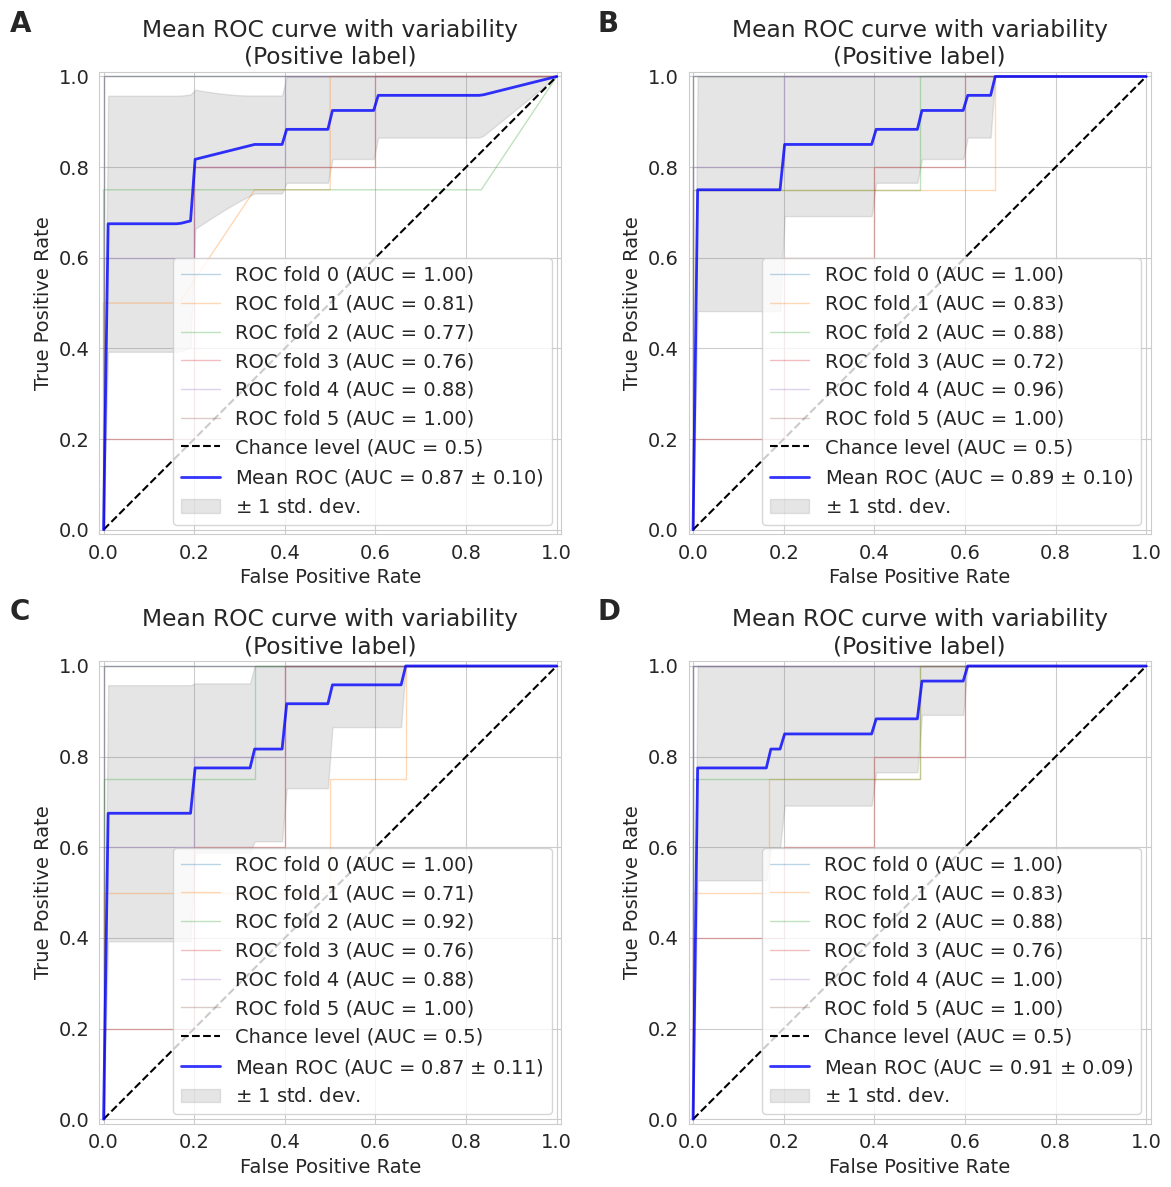

In [42]:
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 2, figure=fig)

ax_data1 = fig.add_subplot(gs[0, 0])
ax_data2 = fig.add_subplot(gs[0, 1])
ax_data3 = fig.add_subplot(gs[1, 0])
ax_data4 = fig.add_subplot(gs[1, 1])

create_curve_roc(clf_extraTree, train_data, train_response, ax_data1)
create_curve_roc(clf_linearSVC, train_data, train_response, ax_data2)
create_curve_roc(clf_nusvc, train_data, train_response, ax_data3)
create_curve_roc(clf_ridge, train_data, train_response, ax_data4)

fig.text(0.01, 0.99, "A", ha='left', va='top', fontsize=20, fontweight='bold')
fig.text(0.5, 0.99, "B", ha='left', va='top', fontsize=20, fontweight='bold')
fig.text(0.01, 0.5, "C", ha='left', va='top', fontsize=20, fontweight='bold')
fig.text(0.5, 0.5, "D", ha='left', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.savefig("../../results/training_models/roc_curve.png", dpi=300)



### Evaluating models using the independent dataset

In [43]:
test_data = pd.read_csv("../../results/processed_dataset/3_test_independent_dataset.csv")
test_response = test_data["MSPH"]
test_values = test_data.drop(columns=["MSPH"]).values

In [44]:
scaler_instance = load("../../results/processed_dataset/scaler_instance.joblib")
test_values_scaler = scaler_instance.transform(test_values)

In [45]:
predictions_extratree = clf_extraTree.predict(test_values_scaler)
predictions_linearSVC = clf_linearSVC.predict(test_values_scaler)
predictions_nusvc = clf_nusvc.predict(test_values_scaler)
predictions_ridge = clf_ridge.predict(test_values_scaler)

In [46]:
extratree_test_metric = get_metrics(test_response, predictions_extratree)
linearSVC_test_metric = get_metrics(test_response, predictions_linearSVC)
nusvc_test_metric = get_metrics(test_response, predictions_nusvc)
ridge_test_metric = get_metrics(test_response, predictions_ridge)

matrix_data = [
    extratree_test_metric,
    linearSVC_test_metric,
    nusvc_test_metric,
    ridge_test_metric
]

df_performances = pd.DataFrame(data=matrix_data, columns=[
          'F1_val', 'Recall_val', 'Precision_vall', 'Accuracy_val',
          'matthews_corrcoef_val','sensitivity','specificity'])
df_performances["Algorithm"] = ["ExtraTree", "LinearSVC", "NuSVC", "RidgeClassifier"]
df_performances

,F1_val,Recall_val,Precision_vall,Accuracy_val,matthews_corrcoef_val,sensitivity,specificity,Algorithm
0,0.666667,0.75,0.6,0.666667,0.35,0.6,0.75,ExtraTree
1,0.777778,0.80,0.8,0.800000,0.55,0.8,0.75,LinearSVC
2,0.777778,0.80,0.8,0.800000,0.55,0.8,0.75,NuSVC
3,0.777778,0.80,0.8,0.800000,0.55,0.8,0.75,RidgeClassifier


In [47]:
df_discarded = pd.read_csv("../../results/processed_dataset/2_data_not_used_to_train.csv")
discared_neg = df_discarded["MSPH"].values
df_discarded_values = df_discarded.drop(columns=["MSPH"]).values

discarded_examples = scaler_instance.transform(df_discarded_values)

In [48]:
predictions_extratree = clf_extraTree.predict(discarded_examples)
predictions_linearSVC = clf_linearSVC.predict(discarded_examples)
predictions_nusvc = clf_nusvc.predict(discarded_examples)
predictions_ridge = clf_ridge.predict(discarded_examples)

In [49]:
extratree_test_metric = get_metrics(discared_neg, predictions_extratree)
linearSVC_test_metric = get_metrics(discared_neg, predictions_linearSVC)
nusvc_test_metric = get_metrics(discared_neg, predictions_nusvc)
ridge_test_metric = get_metrics(discared_neg, predictions_ridge)

matrix_data = [
    extratree_test_metric,
    linearSVC_test_metric,
    nusvc_test_metric,
    ridge_test_metric
]

df_performances = pd.DataFrame(data=matrix_data, columns=[
          'F1_val', 'Recall_val', 'Precision_vall', 'Accuracy_val',
          'matthews_corrcoef_val','sensitivity','specificity'])
df_performances["Algorithm"] = ["ExtraTree", "LinearSVC", "NuSVC", "RidgeClassifier"]
df_performances

,F1_val,Recall_val,Precision_vall,Accuracy_val,matthews_corrcoef_val,sensitivity,specificity,Algorithm
0,0.645161,0.0,0.0,0.0,0.0,NaN,0.645161,ExtraTree
1,0.629032,0.0,0.0,0.0,0.0,NaN,0.629032,LinearSVC
2,0.677419,0.0,0.0,0.0,0.0,NaN,0.677419,NuSVC
3,0.693548,0.0,0.0,0.0,0.0,NaN,0.693548,RidgeClassifier


In [50]:
dump(clf_extraTree, "../../results/training_models/clf_extraTree.joblib")
dump(clf_linearSVC, "../../results/training_models/clf_linearSVC.joblib")
dump(clf_nusvc, "../../results/training_models/clf_NuSVC.joblib")
dump(clf_ridge, "../../results/training_models/clf_ridge.joblib")

['../../results/training_models/clf_ridge.joblib']